In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar, plot_run_metric_mesh
import os

from matplotlib.legend_handler import HandlerErrorbar
from matplotlib import cm

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
# download summary file if needed
if not os.path.isfile('summary.h5'):
    import requests
    url = 'https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.1/maf/summary.h5'
    r = requests.get(url)
    open('summary.h5', 'wb').write(r.content)

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(117, 51193)

In [4]:
#data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['ender_a1_v3.1_10yrs'], data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['baseline_v3.0_10yrs']

In [5]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Presto' in col]

['Median PrestoKNe_presto_color_detect UserPointsSlicer',
 'Median PrestoKNe_score_p UserPointsSlicer',
 'Median PrestoKNe_score_s UserPointsSlicer',
 'Sum PrestoKNe_presto_color_detect UserPointsSlicer',
 'Sum PrestoKNe_score_p UserPointsSlicer',
 'Sum PrestoKNe_score_s UserPointsSlicer']

In [6]:
# Pull out the metrics we are interested in and define simple names

name_dict = {
            'best18k parallax HealpixSlicer': 'parallax \nbest 18k',
            'best18k properMotion HealpixSlicer': 'proper motion \nbest 18k',
    'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Fp cov, u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Fp cov, g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Fp cov, r',
            
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
    'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_single_multi_color_detect single model UserPointsSlicer': 'KNe multi-color',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe simple ztfrest',
             'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
    
}
# drop in the units for the columns
units = {'parallax \nbest 18k': 'mas',
         'proper motion \nbest 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe multi-color': 'N',
         'KNe ZTF simple': 'N', 
         'KNe simple ztfrest': 'N',
         'XRB\nearly detect': 'N', 
         'N SN ELAISS1': 'N,',
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Fp cov, u': '',
         'Fp cov, g': '',
         'Fp cov, r': '',
         'Fp cov, i': '',
         'KNe Score, P': 'Score'
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax \nbest 18k', 'proper motion \nbest 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
         #  'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         #'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 #'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 #'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 #'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 #'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

# Updates from baseline 3.0 to potential 3.1

* Minor update to the footprint to include small Euclid swath
* uzy filter loader rather than just uz
* Updated to newer cloud database (expected neutral cahnge)
* Telescope now parks with r-filter in. Should be no filter change time added when coming out of park. (minor bug fix)
* Updated long gaps survey to only attempt log gaps if early pair was sucessful. Also only attempt one starting blob in a night.
* executing long_gaps every 3 days (rather than 6) (related to above)
* Changing the blobs to not have az limits. (minor bug fix)
* Fixed bug in projection for solving blob path. Might be a slight slewtime improvement from it. (moderate bug fix)
* Fix bug that was letting DDFs execute in twilight time
* using a u and g first year coverage weighting of 50 each
* run the twilight neo observations with a 45 degree solar elongation limit, go from airmass limit 2.0 to 2.5
* update start date to May 1, 2025


In [7]:
#[col for col in data_loaded.columns if 'multi' in col]

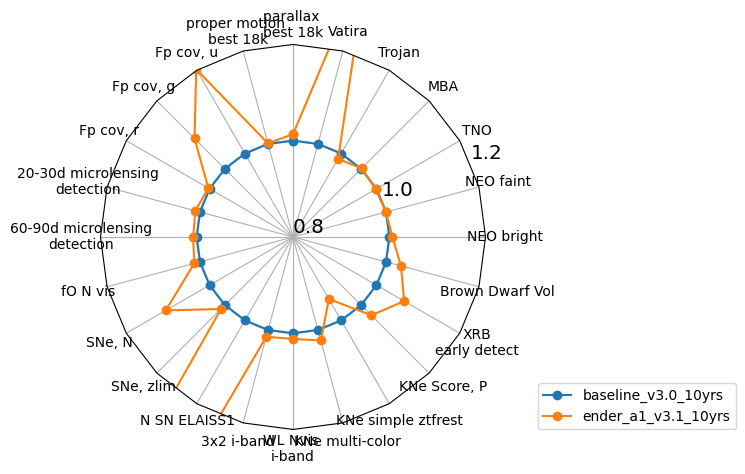

In [8]:
runs = ['baseline_v3.0_10yrs', 'ender_a1_v3.1_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

In [9]:
pd.set_option('display.max_columns', None)
data.loc[runs]

,parallax \nbest 18k,proper motion \nbest 18k,"Fp cov, u","Fp cov, g","Fp cov, r",20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",N SN ELAISS1,3x2 i-band,WL Nvis \ni-band,KNe multi-color,KNe simple ztfrest,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
baseline_v3.0_10yrs,0.792666,0.185683,0.813058,0.901174,0.993823,0.3239,0.4559,795.0,109475.798536,0.293926,37.378088,38.643260,423.0,26619.0,5654.0,228.428876,1950.0,168032.537231,0.9326,0.642155,0.722293,0.924156,0.611053,0.0376
ender_a1_v3.1_10yrs,0.782077,0.185427,0.977539,0.981717,0.997035,0.3341,0.4634,805.0,121007.562022,0.305456,297.421154,39.214641,428.0,27224.0,5366.0,235.320866,2080.0,173433.444317,0.9392,0.641947,0.720883,0.925484,0.598403,0.4445


In [10]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs', 'ender_a1_v3.1_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_data




,parallax \nbest 18k,proper motion \nbest 18k,"Fp cov, u","Fp cov, g","Fp cov, r",20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",N SN ELAISS1,3x2 i-band,WL Nvis \ni-band,KNe multi-color,KNe simple ztfrest,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
retro_baseline_v2.0_10yrs,0.804328,0.176701,0.893276,0.949104,0.960964,0.0883,0.1533,848.0,97124.012102,0.281304,66.749298,34.632263,449.0,23143.0,3982.0,202.730488,720.0,179640.718155,0.9048,0.623933,0.705953,0.943433,0.667158,NaN
baseline_v2.0_10yrs,0.791058,0.184088,0.955776,0.981594,0.994441,0.3116,0.4284,839.0,99302.532220,0.282012,81.438800,37.908126,443.0,25681.0,4544.0,263.696398,1879.0,168086.074111,0.9294,0.642021,0.719635,0.918999,0.588087,0.0039
baseline_v2.1_10yrs,0.806910,0.188258,0.948661,0.984188,0.996912,0.3111,0.4312,838.0,99294.339899,0.283756,40.212476,38.560143,443.0,26415.0,4777.0,243.713720,1918.0,163815.013503,0.9286,0.647553,0.723197,0.927567,0.608979,0.0017
baseline_v2.2_10yrs,0.792958,0.186345,0.871233,0.914268,0.993947,0.3212,0.4462,830.0,112802.099640,0.289980,3.753806,39.794283,440.0,28174.0,5215.0,242.377184,1920.0,172453.127988,0.9304,0.657462,0.723899,0.933507,0.615249,0.0008
baseline_v3.0_10yrs,0.792666,0.185683,0.813058,0.901174,0.993823,0.3239,0.4559,795.0,109475.798536,0.293926,37.378088,38.643260,423.0,26619.0,5654.0,228.428876,1950.0,168032.537231,0.9326,0.642155,0.722293,0.924156,0.611053,0.0376
ender_a1_v3.1_10yrs,0.782077,0.185427,0.977539,0.981717,0.997035,0.3341,0.4634,805.0,121007.562022,0.305456,297.421154,39.214641,428.0,27224.0,5366.0,235.320866,2080.0,173433.444317,0.9392,0.641947,0.720883,0.925484,0.598403,0.4445


(<Figure size 600x600 with 2 Axes>, <Axes: >)

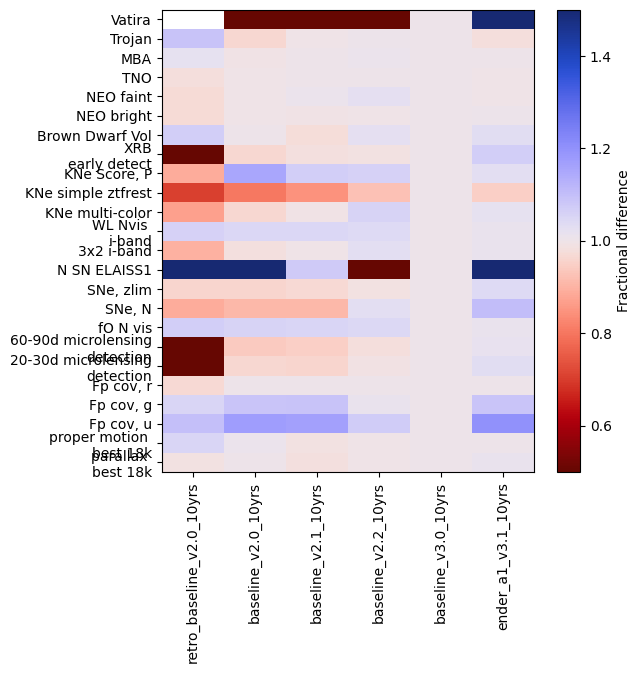

In [11]:
mesh_data = sub_data.copy()
mesh_data['parallax \nbest 18k'] = 1./mesh_data['parallax \nbest 18k']
mesh_data['proper motion \nbest 18k'] = 1./mesh_data['proper motion \nbest 18k']

plot_run_metric_mesh(mesh_data, baseline_run='baseline_v3.0_10yrs')

(<Figure size 600x600 with 2 Axes>, <Axes: >)

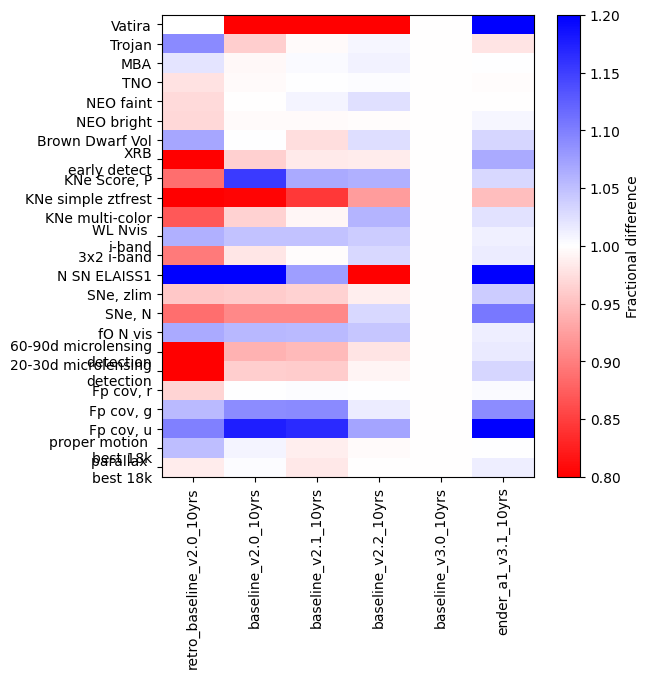

In [12]:
plot_run_metric_mesh(mesh_data, baseline_run='baseline_v3.0_10yrs', cmap=cm.bwr_r, color_range=0.4)

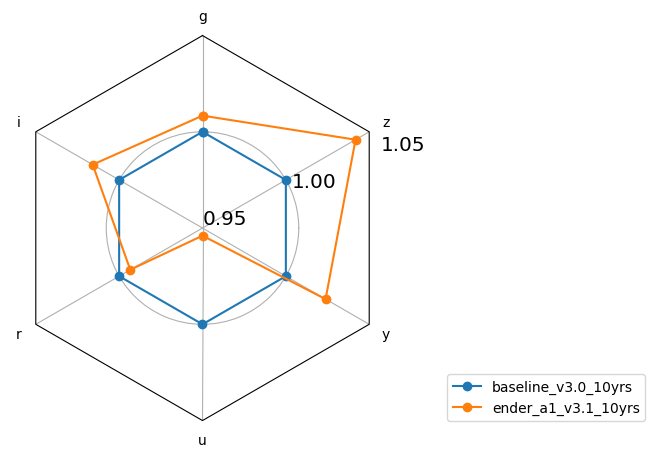

In [13]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [14]:
mag_data.loc[runs]

,g,i,r,u,y,z
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
ender_a1_v3.1_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586


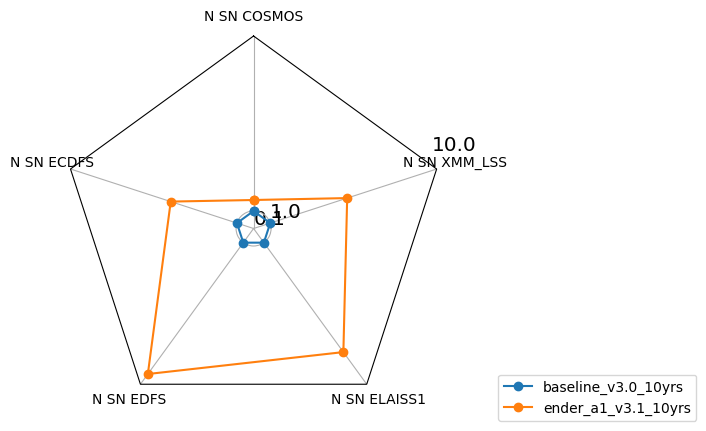

In [15]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 10], bbox_to_anchor=(1.65, 0))

In [16]:
ddf_data.loc[runs]

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335
ender_a1_v3.1_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767


# Major science metrics changes over simulation version

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_19765/3558122600.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


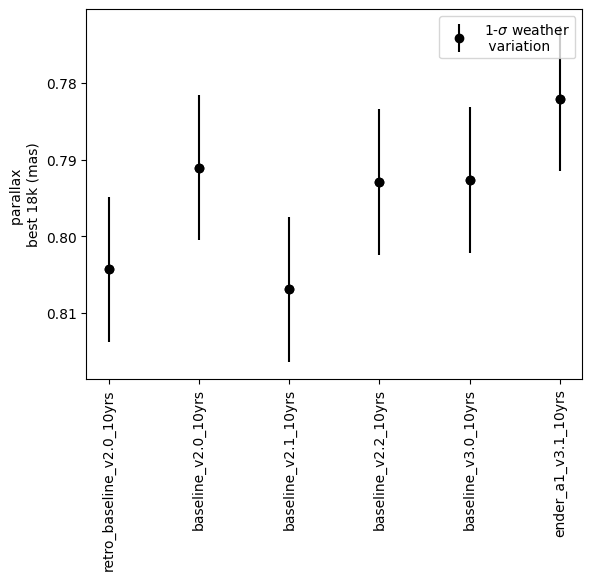

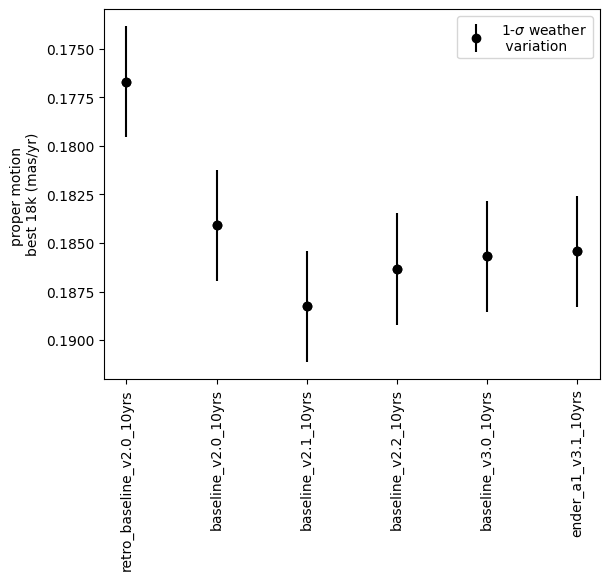

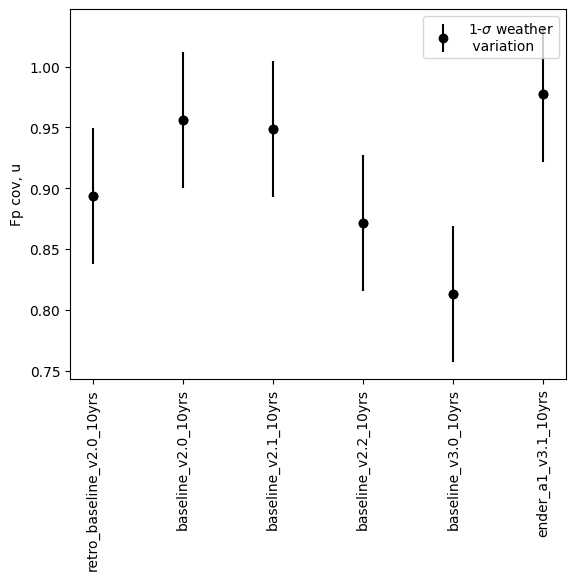

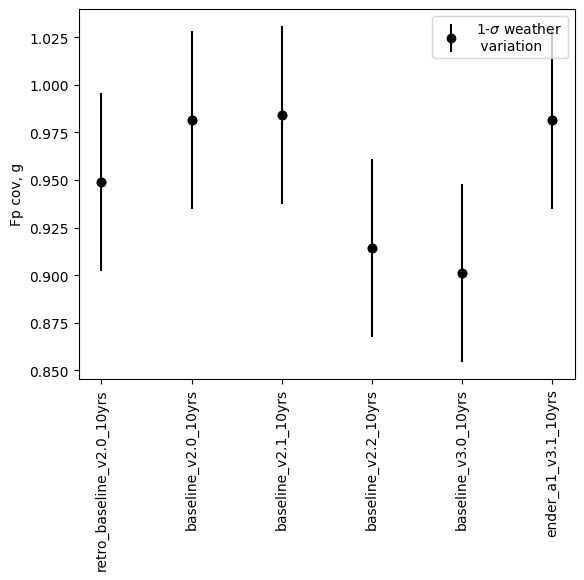

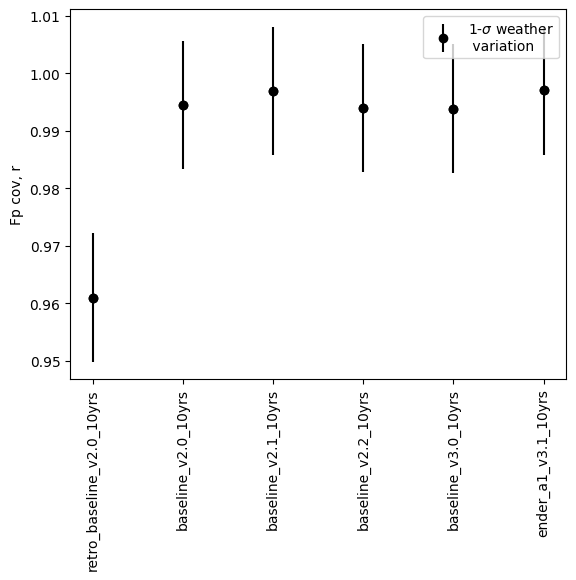

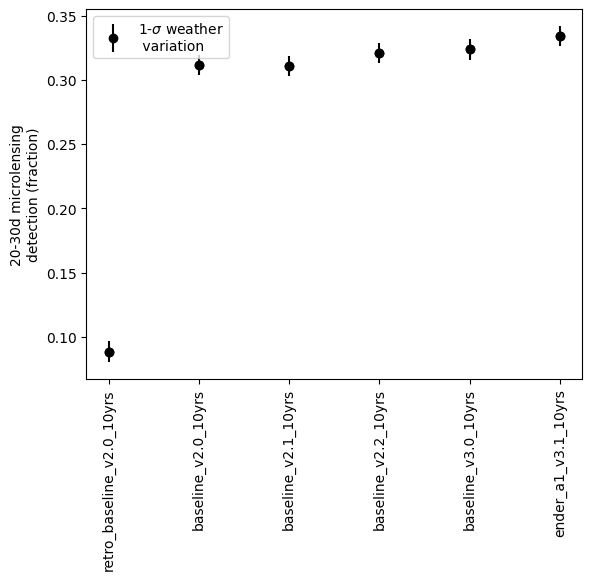

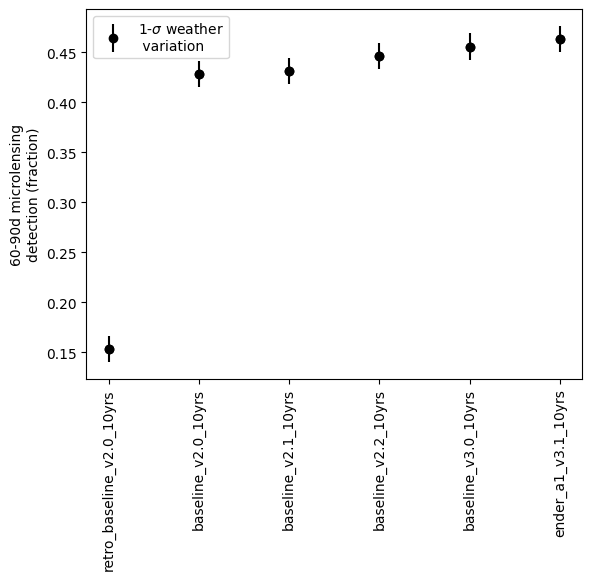

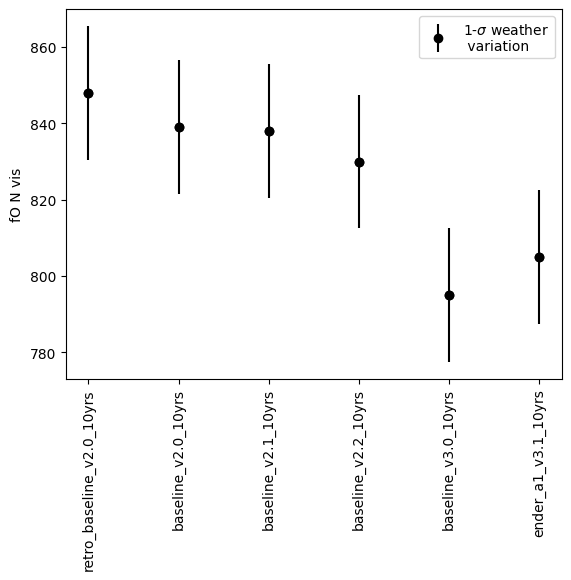

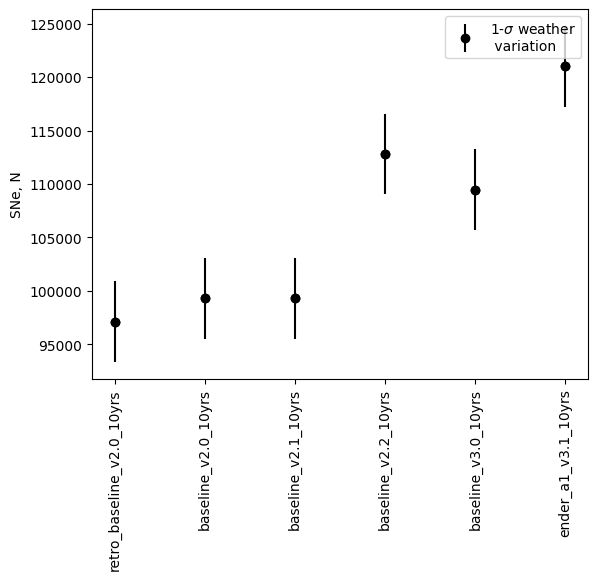

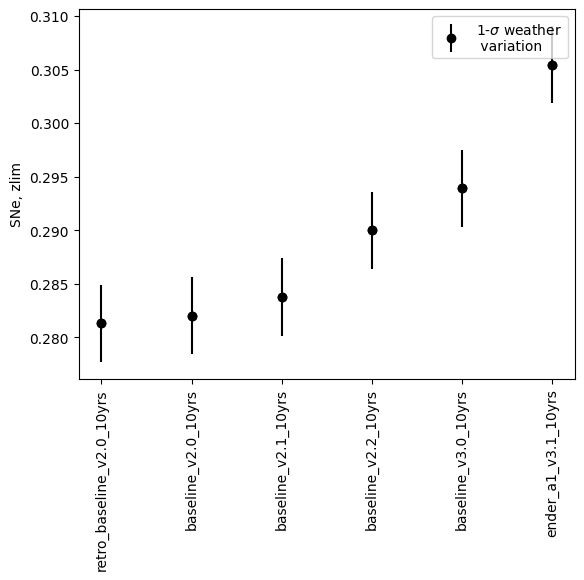

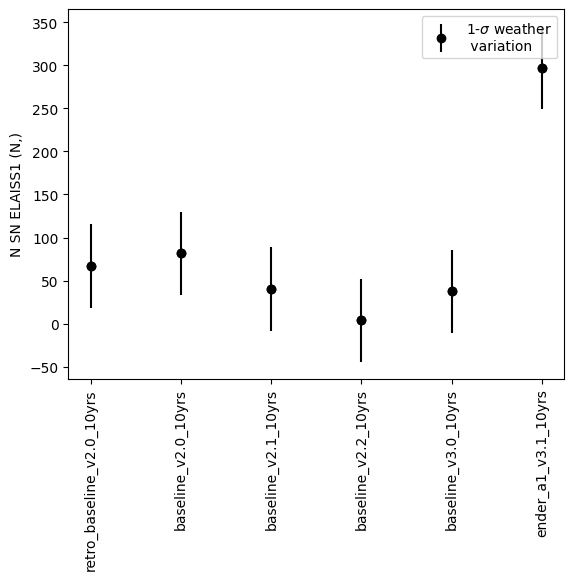

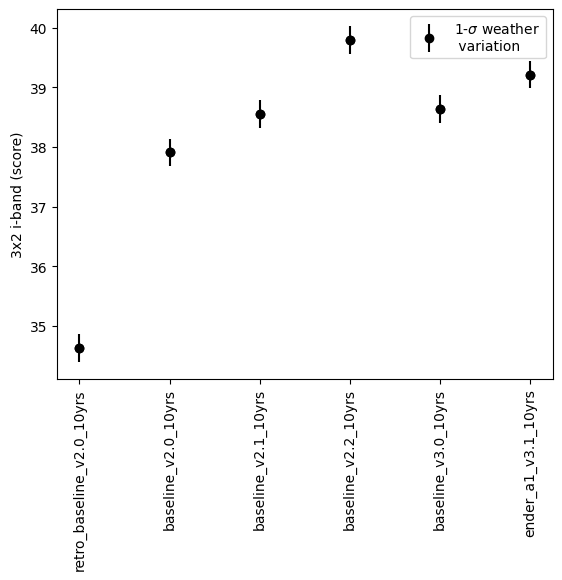

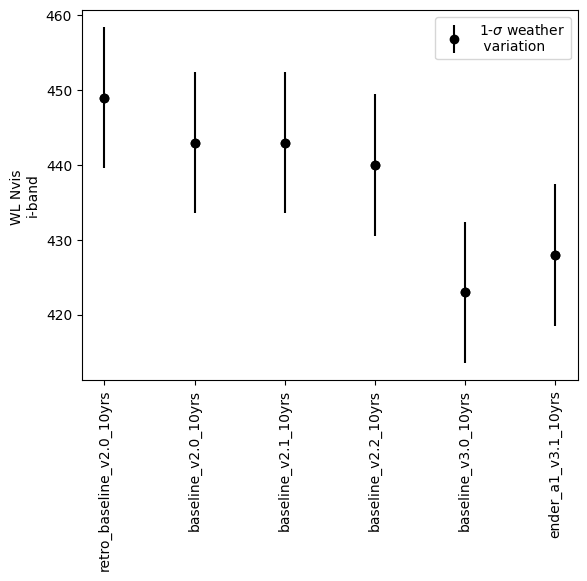

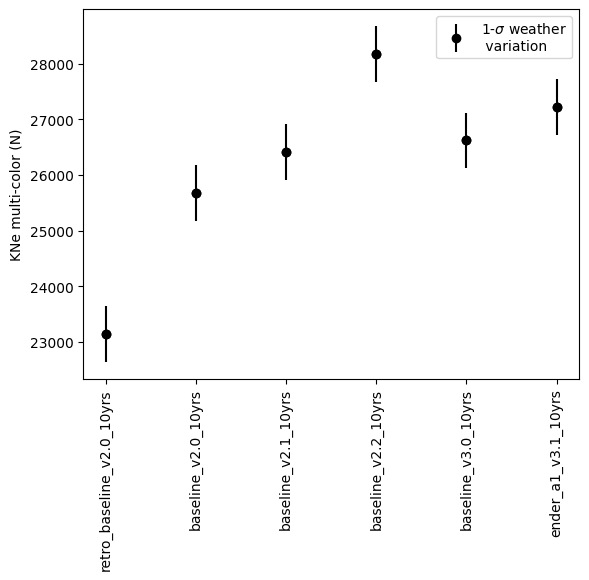

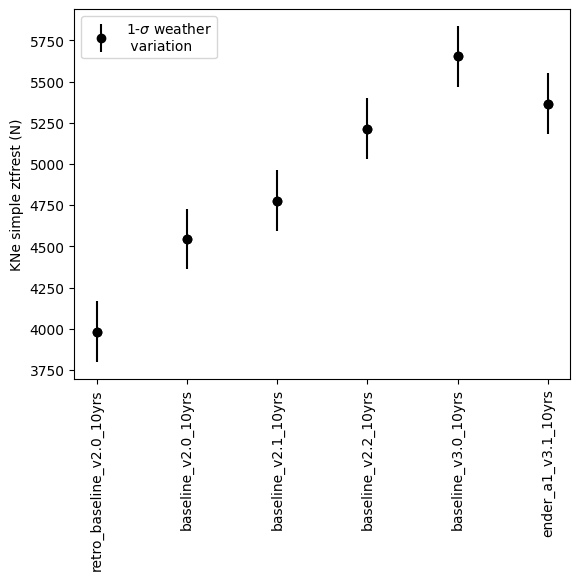

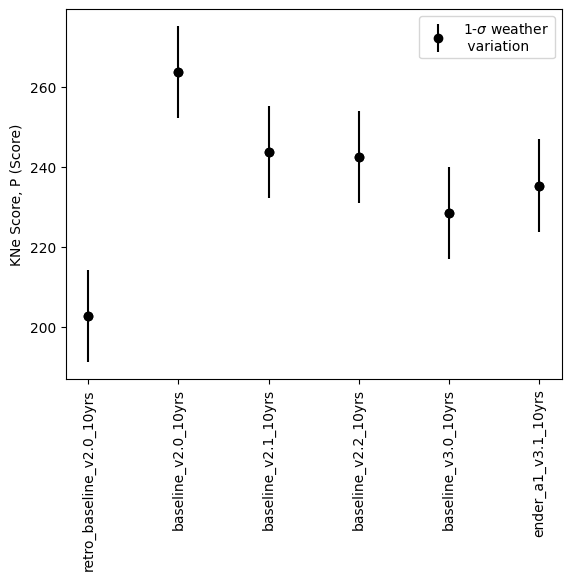

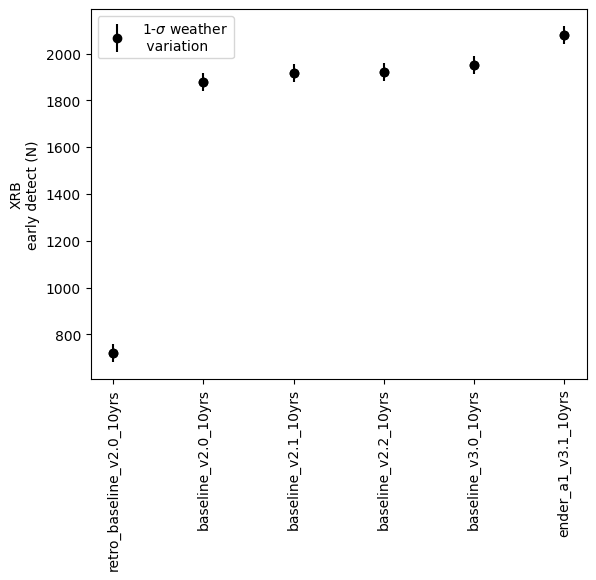

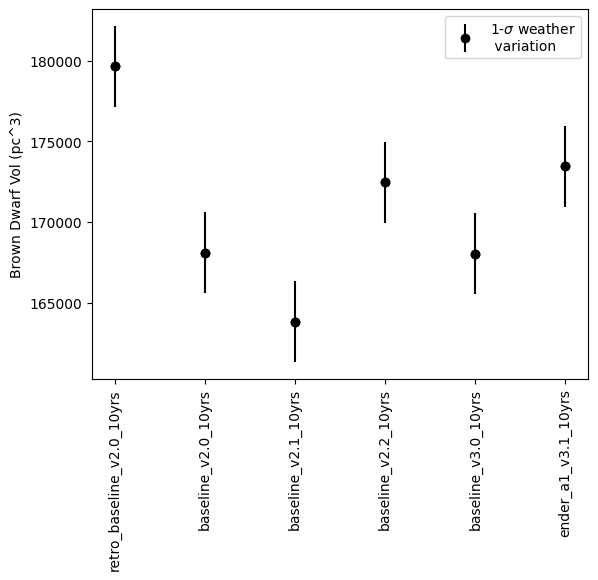

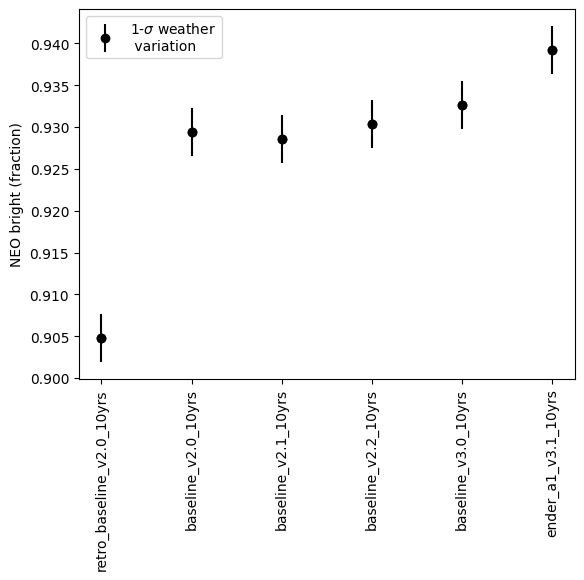

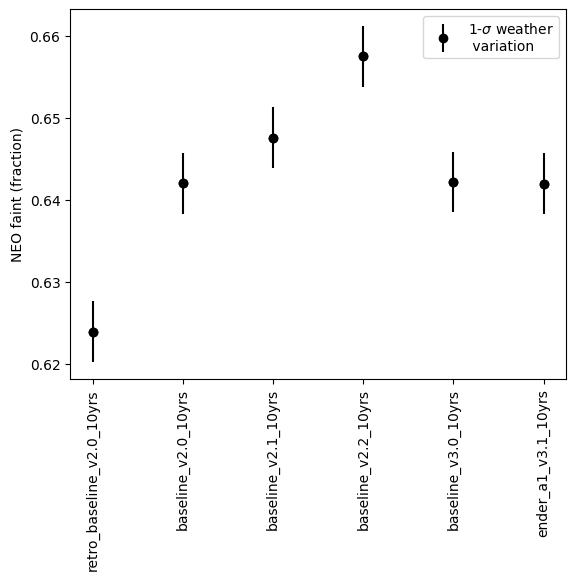

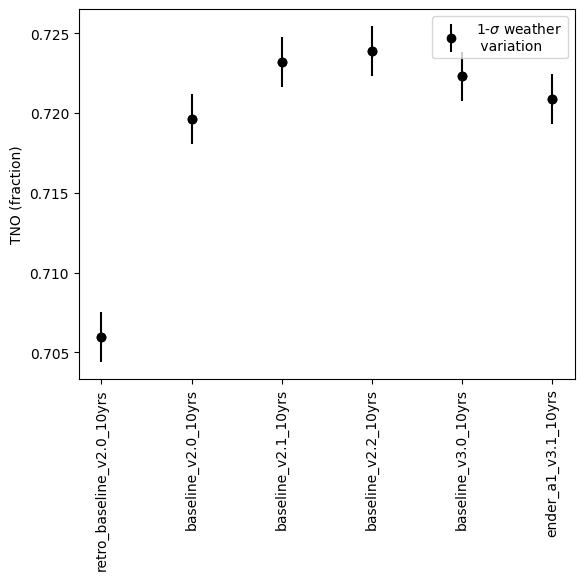

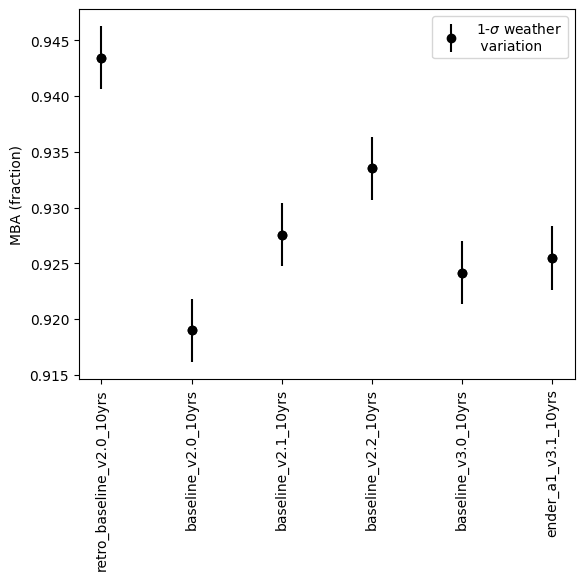

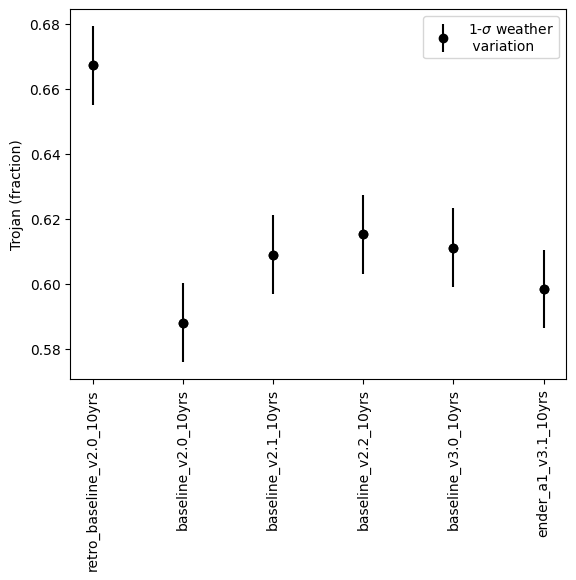

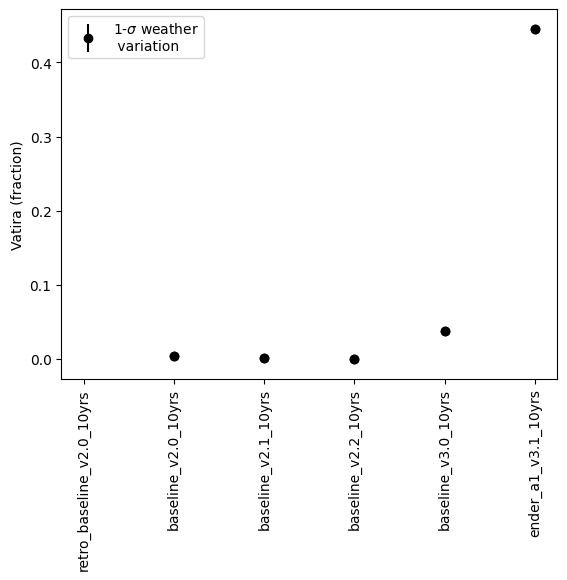

In [17]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if col in list(units.keys()):
        if units[col] != '':
            label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_19765/1579871323.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_ddf[col].values.size), sub_ddf[col], yerr=std_ddf_dict[col], fmt='s', color='k',


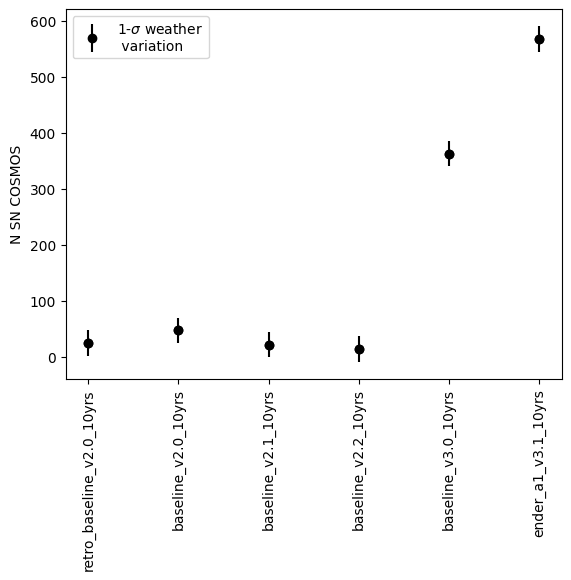

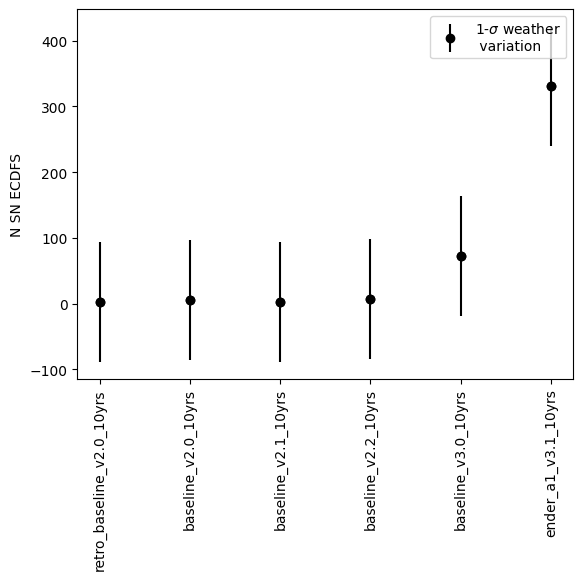

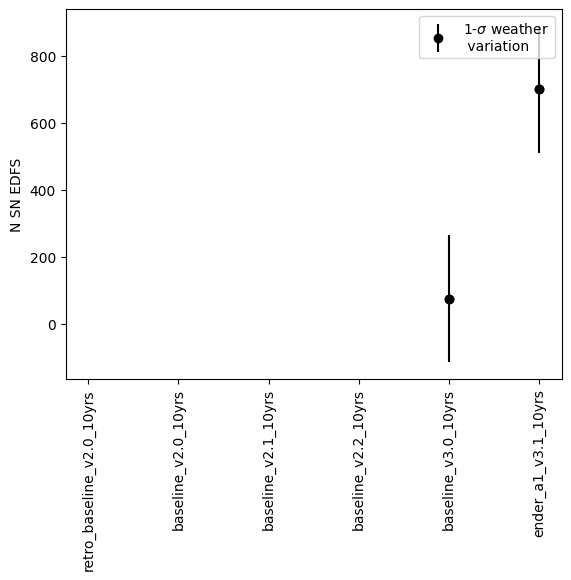

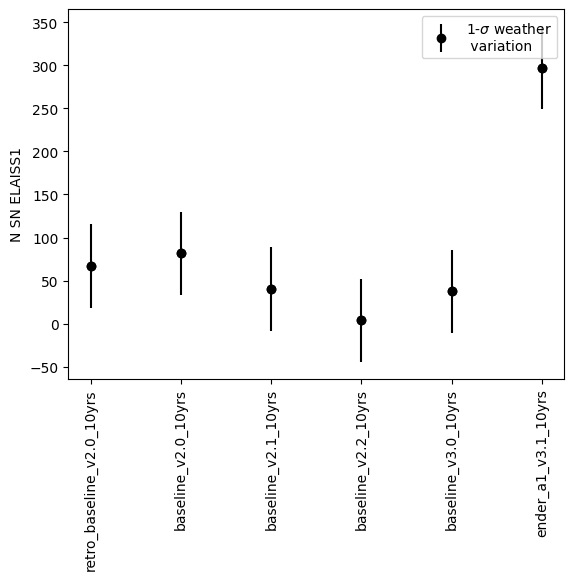

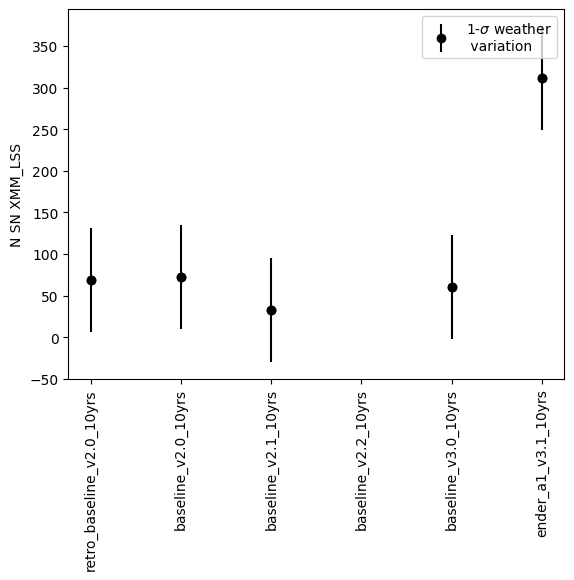

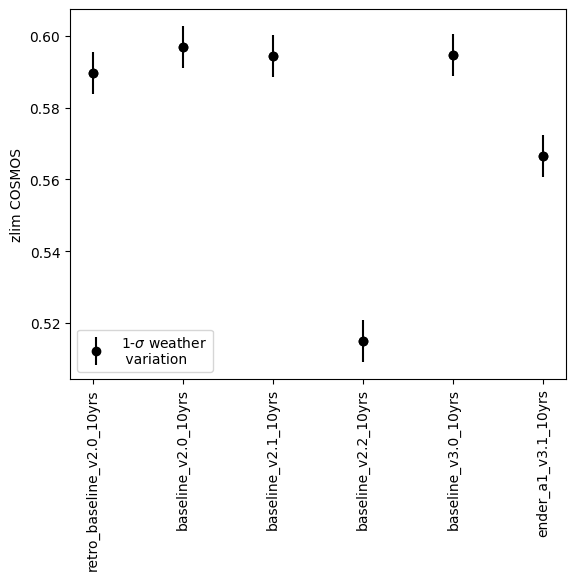

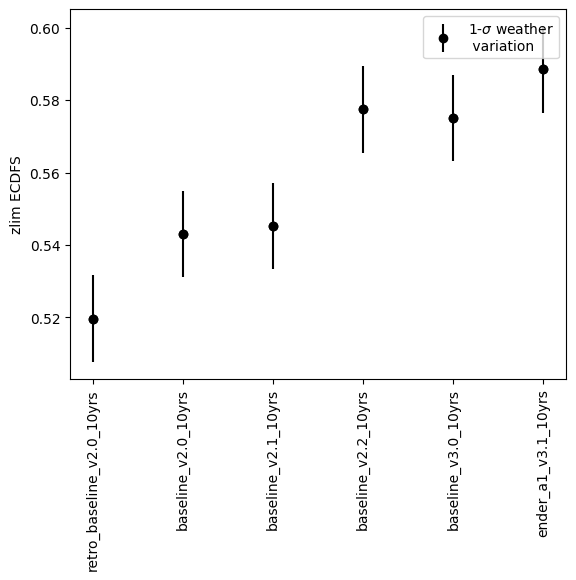

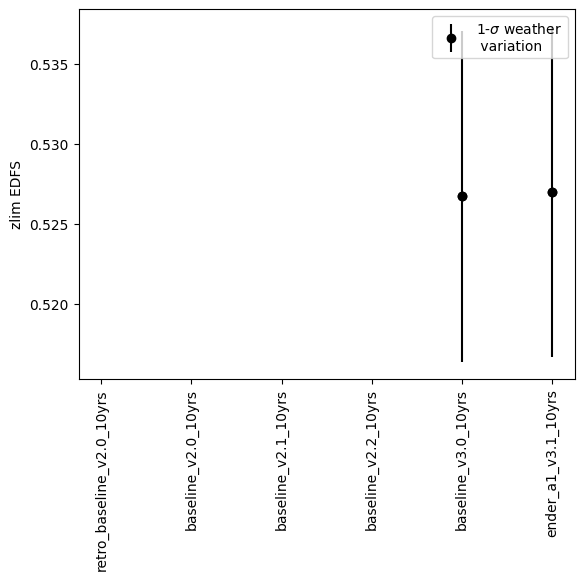

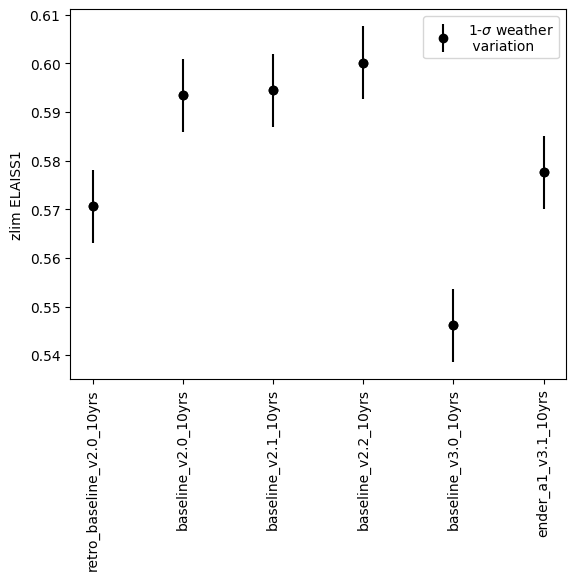

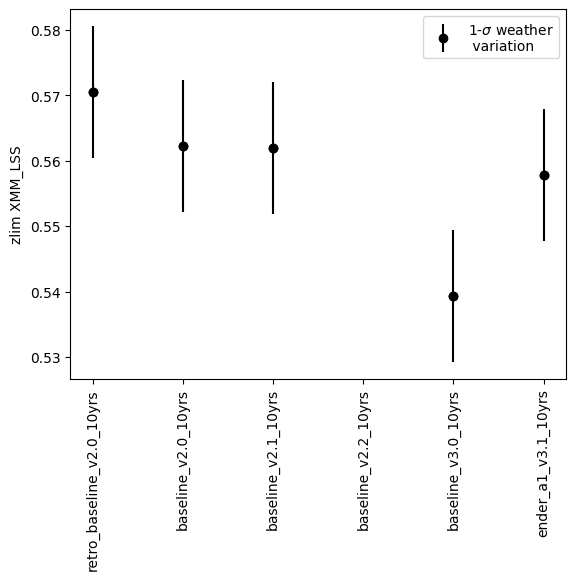

In [18]:
for col in sub_ddf.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_ddf[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_ddf[col].values.size), sub_ddf[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_19765/1447107222.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',


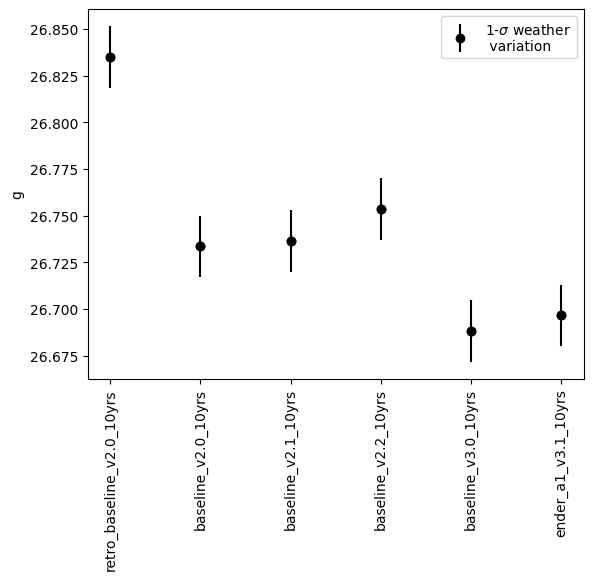

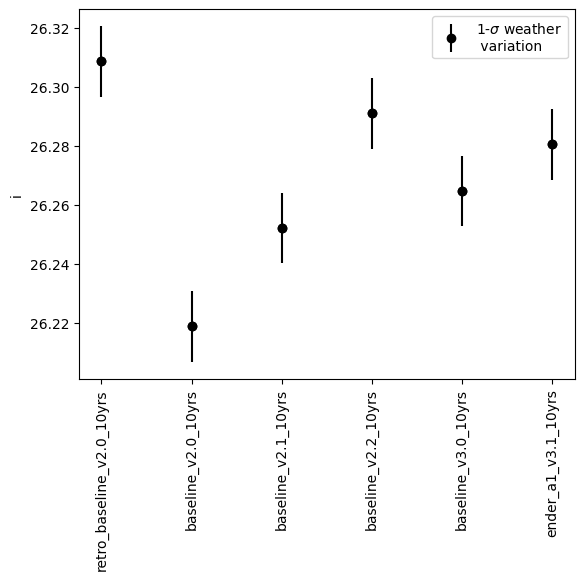

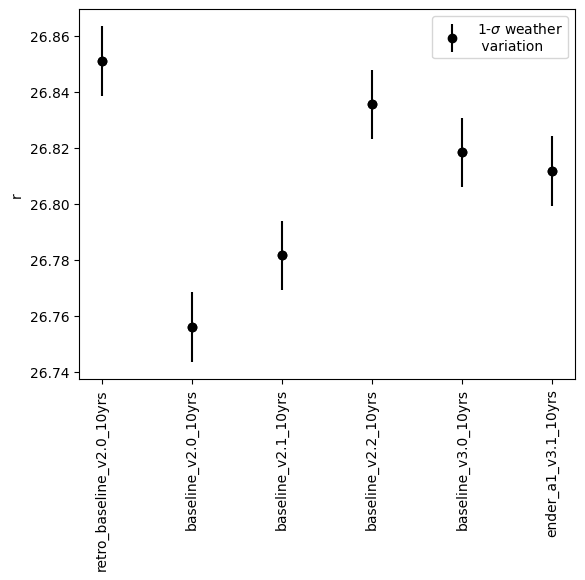

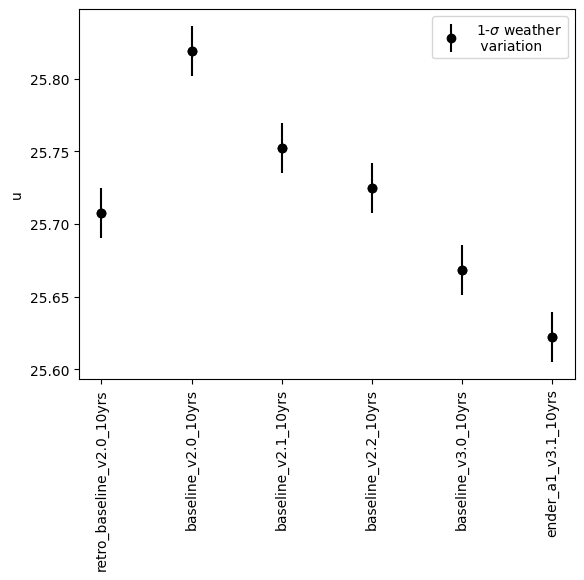

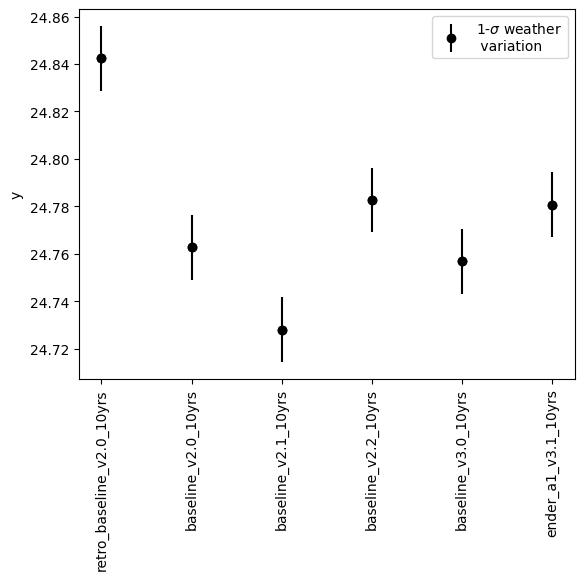

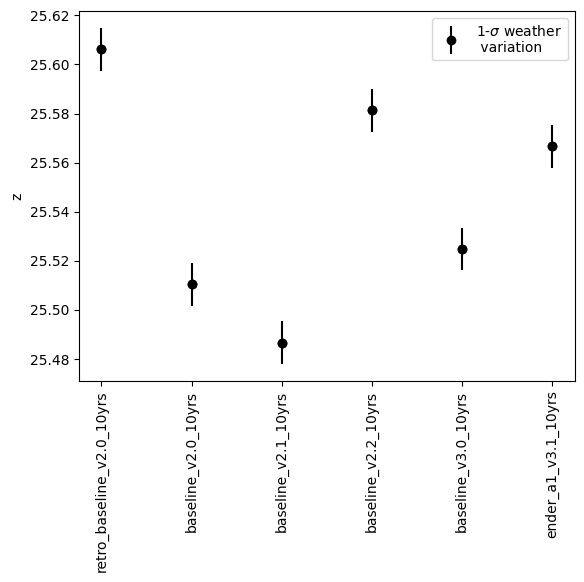

In [19]:
for col in sub_mag.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_mag[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

# Conclusions

* We see a huge gain in Vatira detection (driven by update to twilight NEO survey)
* Huge gain in SNe in the DDFs (driven by new filter loading strategy which eliminates long gaps in z coverage)
* Fixed 1st year coverage for template generation in u and g (basis function weight modifications)
* Median coadded depths remain functionally unchanged in all filters. I guess u has been getting shallower over time. We could turn that up a bit if there's a call for it.
* Mixed results from KNe metrics
    * Not clear why KNe previously showed improvement up to v3.0 (it goes up, it goes down, no one knows why)
    * Overall, we are not a good KNe survey. We are now injecting 500,000 KNe, so the drop in the ZTF simple metric means we are going from detecting 0.9% to 0.7% of the injected objects.
* Very slight dip in Trojan recovery. Probably just the survey start date changing, so the Trojan cloud(s) spend more time in the NES than in WFD. 

